### To Run this notebook, run the following command in the terminal:
#### pip install -r requirements.txt
#### python version: 3.12.6

    

### Importing the libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load the fama french data

In [6]:
ff5_data = pd.read_csv("data/raw/ff5_data.csv")

# Convert dates, coercing errors to NaT (Not a Time)
ff5_data['Date'] = pd.to_datetime(ff5_data['Date'], format='%Y%m%d', errors='coerce')

# Remove rows where Date conversion failed
ff5_data = ff5_data.dropna(subset=['Date'])

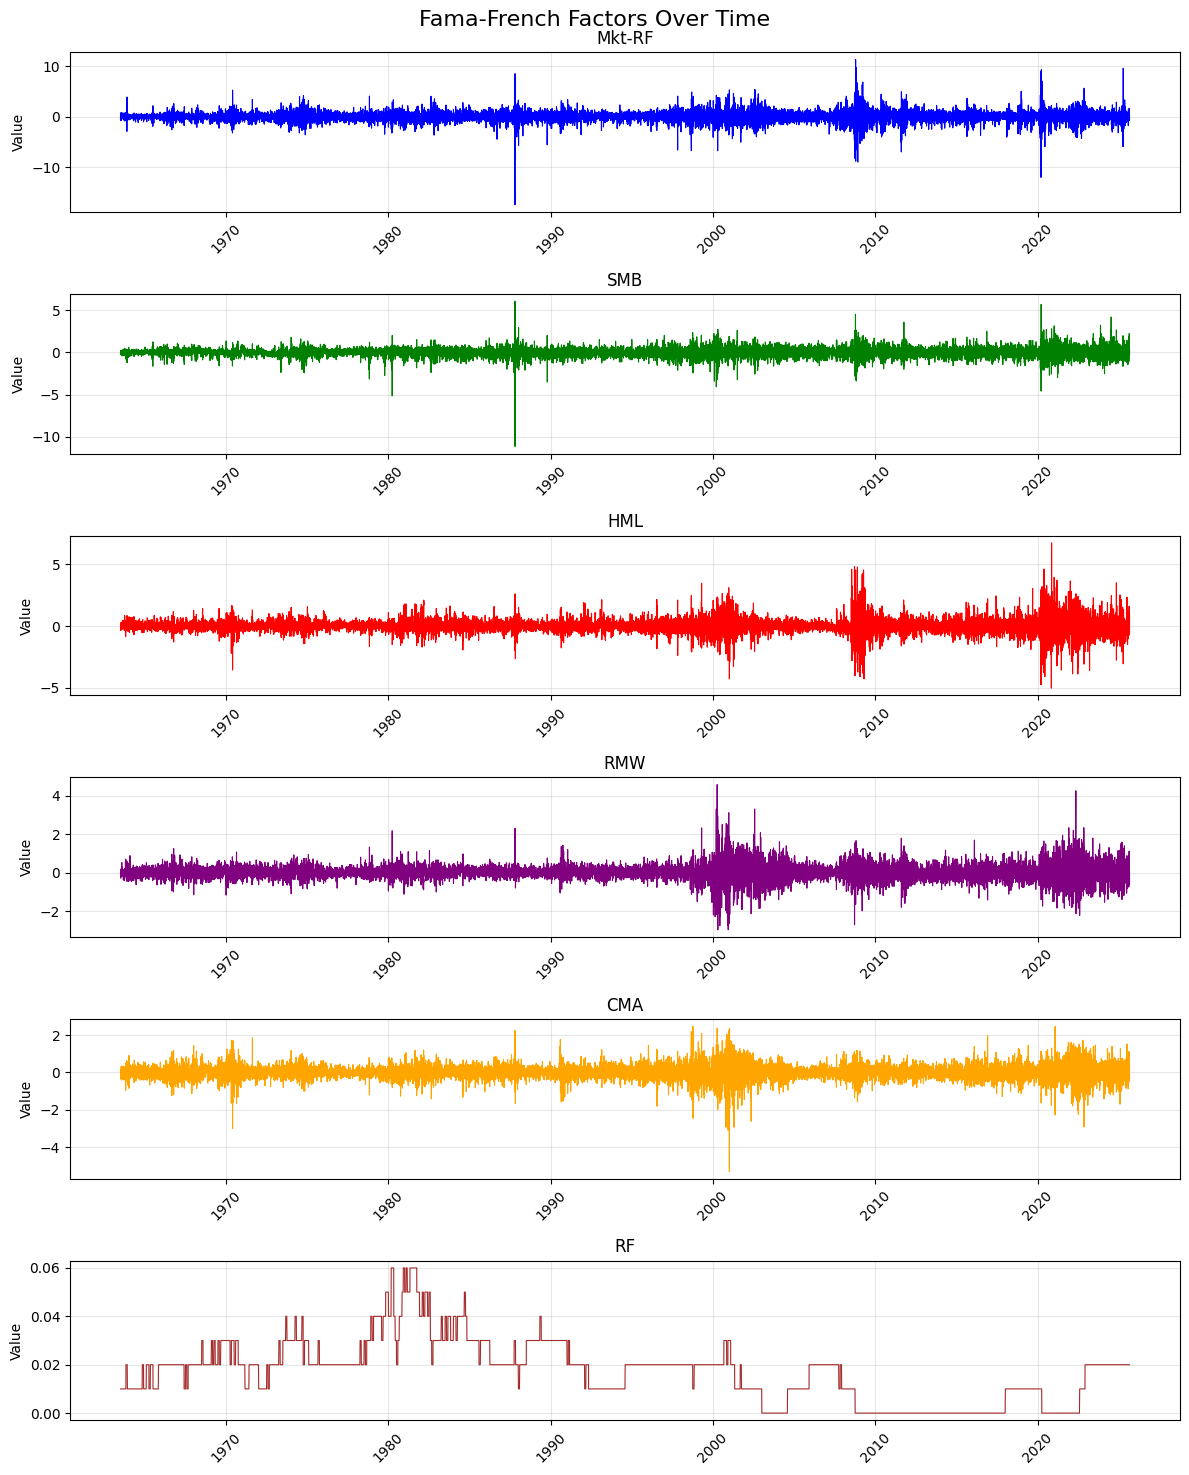

In [7]:
# Set Date as index for better plotting
ff5_data.set_index('Date', inplace=True)

# Plot each feature in subplots
features = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

fig, axes = plt.subplots(6, 1, figsize=(12, 15))
fig.suptitle('Fama-French Factors Over Time', fontsize=16)

for i, (feature, color) in enumerate(zip(features, colors)):
    axes[i].plot(ff5_data.index, ff5_data[feature], color=color, linewidth=0.8)
    axes[i].set_title(f'{feature}', fontsize=12)
    axes[i].set_ylabel('Value')
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Download the current S&P500 ticker and market cap data for daily returns

In [8]:
import pandas as pd
import yfinance as yf
from datetime import datetime
import requests
from io import StringIO

# Download S&P 500 ticker list from Wikipedia with user agent
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

response = requests.get(url, headers=headers)
sp500_table = pd.read_html(StringIO(response.text))
sp500_df = sp500_table[0]

# Display the first few rows
print("S&P 500 Companies:")
print(sp500_df.head())
print(f"\nTotal companies: {len(sp500_df)}")

# Get the ticker symbols
tickers = sp500_df['Symbol'].tolist()



S&P 500 Companies:
  Symbol             Security             GICS Sector  \
0    MMM                   3M             Industrials   
1    AOS          A. O. Smith             Industrials   
2    ABT  Abbott Laboratories             Health Care   
3   ABBV               AbbVie             Health Care   
4    ACN            Accenture  Information Technology   

                GICS Sub-Industry    Headquarters Location  Date added  \
0        Industrial Conglomerates    Saint Paul, Minnesota  1957-03-04   
1               Building Products     Milwaukee, Wisconsin  2017-07-26   
2           Health Care Equipment  North Chicago, Illinois  1957-03-04   
3                   Biotechnology  North Chicago, Illinois  2012-12-31   
4  IT Consulting & Other Services          Dublin, Ireland  2011-07-06   

       CIK      Founded  
0    66740         1902  
1    91142         1916  
2     1800         1888  
3  1551152  2013 (1888)  
4  1467373         1989  

Total companies: 503


In [9]:
sp500_df.to_csv("data/raw/sp500.csv", index=False)

In [10]:
# Download monthly data with proper parameters
start_date = '2005-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

print("=" * 60)
print("DOWNLOADING S&P 500 DATA")
print("=" * 60)

# Download S&P 500 index data (^GSPC) - monthly
print("\n[1/2] Downloading S&P 500 Index (^GSPC)...")
gspc_data = yf.download(
    tickers='^GSPC',
    start=start_date,
    end=end_date,
    interval='1mo',  # Monthly data
    progress=True,
    auto_adjust=True  # Use adjusted prices
)

# Download all S&P 500 stocks - monthly
print("\n[2/2] Downloading all S&P 500 stocks...")
price_data = yf.download(
    tickers=tickers,  # List of all S&P 500 tickers
    start=start_date,
    end=end_date,
    interval='1mo',  # Options: '1d', '1wk', '1mo', '3mo'
    threads=True,  # Parallel downloads for speed
    progress=True,
    auto_adjust=True,  # Automatically adjust for splits/dividends
    group_by='column'  # Group by column (default): columns are OHLCV, tickers are sub-columns
)

# Calculate monthly returns (with auto_adjust=True, use 'Close' not 'Adj Close')
monthly_returns = price_data['Close'].pct_change(fill_method=None)
gspc_monthly_returns = gspc_data['Close'].pct_change(fill_method=None)

print("\n" + "=" * 60)
print("DOWNLOAD SUMMARY")
print("=" * 60)
print(f" Price data shape: {price_data.shape}")
print(f"Monthly returns shape: {monthly_returns.shape}")
print(f"Date range: {monthly_returns.index[0].strftime('%Y-%m-%d')} to {monthly_returns.index[-1].strftime('%Y-%m-%d')}")
print(f"Total months: {len(monthly_returns)}")
print(f"Successfully downloaded: {monthly_returns.shape[1]} stocks")
print("=" * 60)

DOWNLOADING S&P 500 DATA

[1/2] Downloading S&P 500 Index (^GSPC)...


[*********************100%***********************]  1 of 1 completed
[                       0%                       ]


[2/2] Downloading all S&P 500 stocks...


[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1mo 2005-01-01 -> 2025-10-28)')
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')



DOWNLOAD SUMMARY
 Price data shape: (250, 2517)
Monthly returns shape: (250, 503)
Date range: 2005-01-01 to 2025-10-01
Total months: 250
Successfully downloaded: 503 stocks


In [11]:
monthly_returns

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-02-01,0.085481,0.166710,NaN,NaN,0.027218,0.129322,-0.019194,0.085237,0.023127,-0.004132,...,0.072596,0.091672,-0.025838,0.226938,NaN,NaN,0.054695,0.089410,-0.020813,NaN
2005-03-01,-0.075000,-0.071110,NaN,NaN,0.013699,-0.034716,-0.054795,0.087773,-0.014175,0.023453,...,0.030018,-0.053514,-0.030474,-0.053990,NaN,NaN,0.062115,-0.094179,-0.047724,NaN
2005-04-01,-0.065315,-0.134629,NaN,NaN,0.054483,-0.001249,-0.101449,-0.114461,-0.056170,-0.268104,...,0.001606,-0.218483,0.012446,-0.043121,NaN,NaN,-0.093611,0.046395,0.005685,NaN
2005-05-01,0.157108,0.102607,NaN,NaN,-0.013048,0.116529,0.072811,0.113839,0.087071,0.103392,...,-0.065005,-0.115035,0.072759,-0.014553,NaN,NaN,0.094341,-0.059445,-0.108878,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-01,0.054414,0.022848,-0.002633,0.025891,0.018191,-0.041982,-0.056594,-0.067961,0.112347,0.104664,...,-0.000430,0.037223,-0.028531,0.063469,0.029618,0.100081,0.034507,-0.010415,0.064154,-0.075194
2025-07-01,-0.027116,0.011698,0.018317,0.000529,-0.072200,-0.054805,-0.106360,-0.075450,-0.051959,0.026525,...,-0.024912,0.163980,0.087388,0.035622,0.117965,0.137347,-0.027197,0.007430,0.099429,-0.065149
2025-08-01,0.096809,0.118370,0.122724,-0.014198,0.055991,0.063560,-0.021826,-0.002768,0.118773,0.156146,...,0.032735,0.162524,-0.014297,0.023737,-0.021159,0.030805,0.019563,0.157665,-0.064686,0.076363


In [12]:
gspc_monthly_returns

Ticker,^GSPC
Date,
2005-01-01,NaN
2005-02-01,0.018903
2005-03-01,-0.019118
2005-04-01,-0.020109
2005-05-01,0.029952
...,...
2025-06-01,0.049607
2025-07-01,0.021667
2025-08-01,0.019066


In [13]:
# Save data as csv files
monthly_returns.to_csv("data/raw/market_data.csv", index=True)
gspc_monthly_returns.to_csv("data/raw/gspc_monthly_returns.csv", index=True)